# SENTIMENT ANALYSIS USING BERT

In [ ]:
# Load spaCy model untuk lemmatisasi (pastikan sudah install spaCy)
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 127.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
! pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

from transformers import AutoTokenizer
import torch
from torch.utils.data import Dataset
from transformers import AutoModelForSequenceClassification
from transformers import EarlyStoppingCallback
from transformers import  Trainer, TrainingArguments
from transformers import pipeline

import matplotlib.pyplot as plt
import seaborn as sns

# Download resource NLTK
nltk.download('stopwords')
nltk.download('wordnet')


nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
data = pd.read_csv('sentiment_analysis.csv')
data

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook
2,2017,8,18,night,Don't angry me,negative,Facebook
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram
...,...,...,...,...,...,...,...
494,2015,10,18,night,"According to , a quarter of families under six...",negative,Twitter
495,2021,2,25,morning,the plan to not spend money is not going well,negative,Instagram
496,2022,5,30,noon,uploading all my bamboozle pictures of facebook,neutral,Facebook
497,2018,8,10,night,congratulations ! you guys finish a month ear...,positive,Twitter


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Year           499 non-null    int64 
 1   Month          499 non-null    int64 
 2   Day            499 non-null    int64 
 3   Time of Tweet  499 non-null    object
 4   text           499 non-null    object
 5   sentiment      499 non-null    object
 6   Platform       499 non-null    object
dtypes: int64(3), object(4)
memory usage: 27.4+ KB


In [ ]:
def preprocess_text(text):
    # 1. Remove URLs, mentions, hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # URL
    text = re.sub(r'@\w+|\#\w+', '', text)  # Mention & hashtag

    # 2. Remove angka dan karakter khusus
    text = re.sub(r'\d+', '', text)  # Angka
    text = re.sub(r'[^\w\s]', '', text)  # Tanda baca

    # 3. Case folding
    text = text.lower()

    # 4. Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # 5. Lemmatization dengan spaCy
    doc = nlp(" ".join(filtered_tokens))
    lemmatized_tokens = [token.lemma_ for token in doc]

    return " ".join(lemmatized_tokens)

# Proses kolom 'text'
data['cleaned_text'] = data['text'].apply(preprocess_text)

In [ ]:
# Proses kolom 'sentiment'
# Misal: ubah 'positive', 'negative' ke 1 dan 0
le = LabelEncoder()
data['sentiment_label'] = le.fit_transform(data['sentiment'])

# Hasil preprocessing
data[['text', 'cleaned_text', 'sentiment', 'sentiment_label']].head()

,text,cleaned_text,sentiment,sentiment_label
0,What a great day!!! Looks like dream.,great day look like dream,positive,2
1,"I feel sorry, I miss you here in the sea beach",feel sorry miss sea beach,positive,2
2,Don't angry me,do not angry,negative,0
3,We attend in the class just for listening teac...,attend class listening teacher read slide nons...,negative,0
4,"Those who want to go, let them go",want go let go,negative,0


In [ ]:
# Split data (gunakan kolom 'cleaned_text' dan 'sentiment_label')
X = data['cleaned_text']
y = data['sentiment_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 399, Test size: 100


In [ ]:
# Proses tokenisasi
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenisasi data training dan testing
train_encodings = tokenizer(
    X_train.tolist(),
    truncation=True,
    padding=True,
    max_length=128  # Sesuaikan panjang maksimum teks
)

test_encodings = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding=True,
    max_length=128
)

In [ ]:
# Buat kelas sentimen
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(val[idx])
            for key, val in self.encodings.items()
        }
        item["labels"] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Konversi ke Dataset
train_dataset = SentimentDataset(train_encodings, y_train)
test_dataset = SentimentDataset(test_encodings, y_test)

In [ ]:
# Pretrained model BERT
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(data['sentiment'].unique())  # Misal 2 kelas (positif/negatif)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./sentiment_model",
    num_train_epochs=50,  # Batas maksimum epoch
    report_to="none",  # Nonaktifkan logging ke W&B
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=100,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    eval_strategy="epoch",  # Evaluasi tiap epoch
    save_strategy="epoch",
    load_best_model_at_end=True,  # Simpan model terbaik
    metric_for_best_model="eval_accuracy",  # Monitor akurasi validasi
    greater_is_better=True,
)

# Define a metric computation function

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]  # Berhenti jika akurasi tidak naik selama 3 epoch
)

In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.000200,1.882764,0.750000,0.745937,0.757198,0.750000
2,0.010300,2.172555,0.740000,0.730468,0.757559,0.740000
3,0.000200,2.492745,0.700000,0.691611,0.726623,0.700000
4,0.076200,2.171114,0.760000,0.761861,0.779078,0.760000
5,0.116300,1.767193,0.770000,0.765846,0.785813,0.770000
6,0.106000,1.625478,0.790000,0.786208,0.815000,0.790000
7,0.108500,1.750272,0.760000,0.757158,0.767372,0.760000
8,0.023700,1.769034,0.750000,0.745766,0.760210,0.750000
9,0.042800,1.808990,0.780000,0.779850,0.782000,0.780000
10,0.000300,2.024473,0.740000,0.730527,0.749512,0.740000


TrainOutput(global_step=600, training_loss=0.02383175277869062, metrics={'train_runtime': 313.1389, 'train_samples_per_second': 63.71, 'train_steps_per_second': 3.992, 'total_flos': 123026078523600.0, 'train_loss': 0.02383175277869062, 'epoch': 24.0})

In [ ]:
# Evaluasi model
trainer.evaluate()

{'eval_loss': 1.646639108657837,
 'eval_accuracy': 0.81,
 'eval_f1': 0.8091241617413049,
 'eval_precision': 0.8097873506838248,
 'eval_recall': 0.81,
 'eval_runtime': 0.1824,
 'eval_samples_per_second': 548.301,
 'eval_steps_per_second': 10.966,
 'epoch': 24.0}

In [ ]:
# Prediksi dan ambil label unik dari data
test_predictions = trainer.predict(test_dataset)
y_pred = np.argmax(test_predictions.predictions, axis=1)
y_true = y_test.to_numpy()

# Ambil label unik (otomatis dari data)
unique_labels = sorted(data['sentiment_label'].unique())

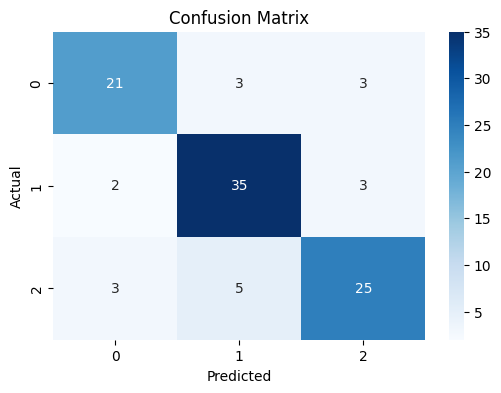

In [ ]:
# buat confusion matriks
cm = confusion_matrix(y_true, y_pred)

# Visualisasi tanpa nama label
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# classification report
print(classification_report(y_true, y_pred, labels=unique_labels))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79        27
           1       0.81      0.88      0.84        40
           2       0.81      0.76      0.78        33

    accuracy                           0.81       100
   macro avg       0.81      0.80      0.81       100
weighted avg       0.81      0.81      0.81       100



In [ ]:
# Cek mapping label (jika menggunakan LabelEncoder)
print("Label mapping:", dict(zip(unique_labels, le.classes_)))

# Contoh output: Label mapping: {0: 'negative', 1: 'positive'}

Label mapping: {np.int64(0): 'negative', np.int64(1): 'neutral', np.int64(2): 'positive'}


In [ ]:
# save model dan hasil tokenisasi
model.save_pretrained("./sentiment_model")
tokenizer.save_pretrained("./sentiment_model")

('./sentiment_model/tokenizer_config.json',
 './sentiment_model/special_tokens_map.json',
 './sentiment_model/vocab.txt',
 './sentiment_model/added_tokens.json',
 './sentiment_model/tokenizer.json')

In [ ]:
# Prediksi model dengan pipeline

sentiment_pipeline = pipeline(
    "text-classification",
    model="./sentiment_model",
    tokenizer=tokenizer
)

contoh_teks = "This product is terrible and waste of money."
hasil = sentiment_pipeline(contoh_teks)
print(hasil)  # Output: [{'label': 'LABEL_0', 'score': 0.98}]

Device set to use cuda:0


[{'label': 'LABEL_0', 'score': 0.9999748468399048}]


In [ ]:
#save .zip model
!zip -r /content/sentiment_model.zip /content/sentiment_model

  adding: content/sentiment_model/ (stored 0%)
  adding: content/sentiment_model/checkpoint-225/ (stored 0%)
  adding: content/sentiment_model/checkpoint-225/training_args.bin (deflated 51%)
  adding: content/sentiment_model/checkpoint-225/model.safetensors (deflated 7%)
  adding: content/sentiment_model/checkpoint-225/config.json (deflated 51%)
  adding: content/sentiment_model/checkpoint-225/trainer_state.json (deflated 77%)
  adding: content/sentiment_model/checkpoint-225/scheduler.pt (deflated 56%)
  adding: content/sentiment_model/checkpoint-225/optimizer.pt (deflated 27%)
  adding: content/sentiment_model/checkpoint-225/rng_state.pth (deflated 25%)
  adding: content/sentiment_model/vocab.txt (deflated 53%)
  adding: content/sentiment_model/checkpoint-150/ (stored 0%)
  adding: content/sentiment_model/checkpoint-150/training_args.bin (deflated 51%)
  adding: content/sentiment_model/checkpoint-150/model.safetensors (deflated 7%)
  adding: content/sentiment_model/checkpoint-150/conf